In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from matplotlib.colors import LogNorm
from scipy.integrate import odeint
sns.set_context("talk", font_scale=1.4)


# for using LaTeX fonts
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

## Infer Markov Chain transition matrix from political regime time-series data

In [2]:
# load the Polity5 data from the excel data frame
timeSeries = pd.read_excel('./../data/polity5/p5v2018.xls')

In [3]:
nCountries = len(timeSeries['country'].unique()) # numer of countries

In [4]:
# do some cleaning
timeSeries = timeSeries.dropna(subset=['year', 'country', 'polity2'])

In [15]:
# save the countries to a csv
#pd.DataFrame(timeSeries['country'].unique()).to_csv('countriesPolity2.csv')


# load the continent information 
continents = pd.read_csv('./../data/polity5/countriesContinentsPolity2.csv')


In [16]:
timeSeriesContinent = pd.merge(timeSeries, continents, on='country', how='inner')


In [5]:
# functions to calculating the transition probabilities

def estimateTransitionMatrix(data,approach='frequentist'):
    
    # construct some output matrices
    countMatrix=np.zeros((21,21)) # empty transition matrix
    
    # split the timeseries into one for each country 
    uniqueCountries = data['country'].unique()
    countryTimeseries =[]
    
    # count for each country the transitions
    for country in uniqueCountries:
        sortedPolity2Country = data[data['country'] == country].sort_values(by='year')["polity"].tolist()
        T=len(sortedPolity2Country)# number of data points
        for t in range(T-1): # go over all years
            fromTransition = int(sortedPolity2Country[t] + 10)
            toTransition = int(sortedPolity2Country[t+1] + 10)
            
            if  (fromTransition>=0) and ((toTransition>=0)):
                
                # increase the count for this year
                countMatrix[fromTransition,toTransition] = countMatrix[fromTransition,toTransition] + 1
    
    if approach=='frequentist':
        # compute the transition probabilities as count over total outgoing
        P = countMatrix/countMatrix.sum(axis=1)[:,None]
    if approach=='bayesian':
        # we use a Dirichlet prior for each row
        priorMatrix = np.zeros((21,21)) + 1/21
        combinedMatrix = countMatrix + priorMatrix
        # this is the posterior mean
        P = combinedMatrix/combinedMatrix.sum(axis=1)[:,None]
    
    return(P)

def computeSteadyStateBruteForce(transitionMatrix,nSteps,initialCondition=0):
    # computes it the brutal way with iterating the transition
    
    n=transitionMatrix.shape[0] # number of Markov states
    
    if initialCondition==0:
        # if it is zero use a random vector
        x = np.random.rand(n)
        x = x / np.sum(x)
    else:
        # set it to the intial condition that we provided
        x= initialCondition
    # fo over each step
    for i in np.arange(nSteps):
        #x= P_allCountries.dot(x)
        x= x.dot(transitionMatrix)
    
    return(x)

def computeSteadyStateEV(transitionMatrix):
    # compute it as eigenvector
    valsT, vecsT = np.linalg.eig(transitionMatrix.transpose())
    
    # find the index of the eigenvalue closest to 1
    index_ev1 = (np.abs(valsT - 1)).argmin()
    
    v = vecsT[:,index_ev1]
    return((v/np.sum(v)).real) # normalise it for the return and also ignore the imaginary part (from numerical approx.)


def simulateMarkovChain(transitionMatrix,initialCondition,nSteps=100):
    
    n=transitionMatrix.shape[0] # number of states
    
    stateVector=[initialCondition]
    for i in np.arange(nSteps):
        newstate = np.random.choice(np.arange(n), p=transitionMatrix[stateVector[i],:])
        stateVector.append(newstate)
    return(stateVector)
    

def computeHittingTime(transitionMatrix,initialCondition,hittingTarget,rel):
    
    n=transitionMatrix.shape[0] # number of states
    
    hittingTimes = np.zeros(rel)
    
    # go over realisations
    for r in np.arange(rel):
        t=0
        oldstate = initialCondition # we start at the initial condition
        while ((oldstate in hittingTarget) == False):
            t=t+1
            newstate = np.random.choice(np.arange(n), p=transitionMatrix[oldstate,:])
            oldstate = newstate
        # save the number of steps needed
        hittingTimes[r] = t
    return(hittingTimes)  


def createSimpleMarkovChain():
    
    P=np.zeros((2,2)) # empty transition matrix
    
    P[0,0] = 0.9
    P[0,1] = 0.1
    P[1,0] = 0.5
    P[1,1] = 0.5
    
    return(P)

# Analyse the data for each continent seperately

In [46]:
# Africa
timeSeriesAfrica = timeSeriesContinent[timeSeriesContinent['Africa'] == 1]
P_allCountries_Africa = estimateTransitionMatrix(timeSeriesAfrica,approach='bayesian')
steadyStateEV_Africa = computeSteadyStateEV(P_allCountries_Africa)

# Asia
timeSeriesAsia = timeSeriesContinent[timeSeriesContinent['Asia'] == 1]
P_allCountries_Asia = estimateTransitionMatrix(timeSeriesAsia,approach='bayesian')
steadyStateEV_Asia = computeSteadyStateEV(P_allCountries_Asia)

# America
timeSeriesAmerica = timeSeriesContinent[timeSeriesContinent['America'] == 1]
P_allCountries_America = estimateTransitionMatrix(timeSeriesAmerica,approach='bayesian')
steadyStateEV_America = computeSteadyStateEV(P_allCountries_America)

# Europe
timeSeriesEurope = timeSeriesContinent[timeSeriesContinent['Europe'] == 1]
P_allCountries_Europe = estimateTransitionMatrix(timeSeriesEurope,approach='bayesian')
steadyStateEV_Europe = computeSteadyStateEV(P_allCountries_Europe)

# Oceania
timeSeriesOceania = timeSeriesContinent[timeSeriesContinent['Oceania'] == 1]
P_allCountries_Oceania = estimateTransitionMatrix(timeSeriesOceania,approach='bayesian')
steadyStateEV_Oceania = computeSteadyStateEV(P_allCountries_Oceania)

# All
#timeSeriesOceania = timeSeriesContinent[timeSeriesContinent['Oceania'] == 1]
P_allCountries_All = estimateTransitionMatrix(timeSeries,approach='bayesian')
steadyStateEV_All = computeSteadyStateEV(P_allCountries_All)


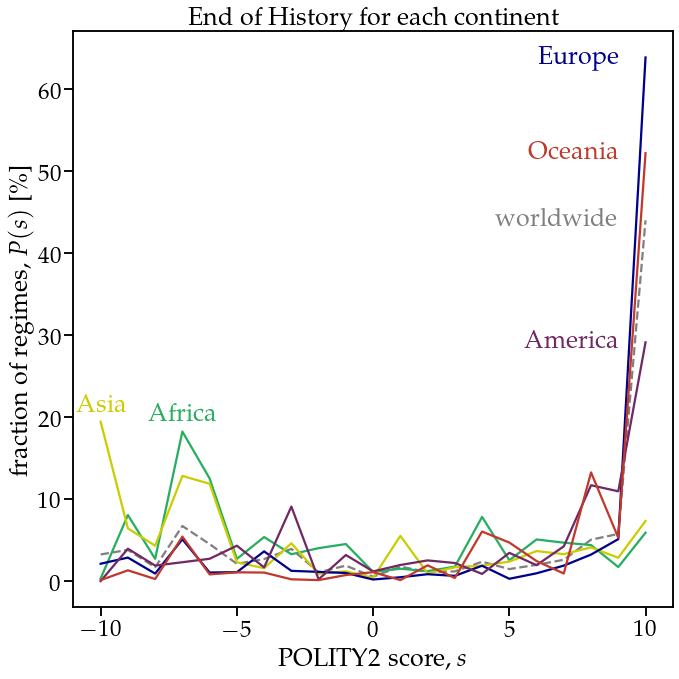

In [83]:
plt.figure(figsize=(10,10))

plt.plot(np.arange(-10,11,1),100*steadyStateEV_All,label='Worldwide', linestyle='dashed',color='#808080')

africaColour = '#27AE60'
asiaColour = '#CCCC00'
europeColour = '#00008B'
americaColour = '#702963'
oceaniaColour = '#C0392B'

plt.plot(np.arange(-10,11,1),100*steadyStateEV_Africa,label='Africa',color=africaColour)
plt.plot(np.arange(-10,11,1),100*steadyStateEV_Asia,label='Asia',color=asiaColour)
plt.plot(np.arange(-10,11,1),100*steadyStateEV_Europe,label='Europe',color=europeColour)
plt.plot(np.arange(-10,11,1),100*steadyStateEV_America,label='America',color=americaColour)
plt.plot(np.arange(-10,11,1),100*steadyStateEV_Oceania,label='Oceania',color=oceaniaColour)

# add legend text

plt.text(-7,100*steadyStateEV_Africa[3]+2,'Africa',ha='center',va='center',color=africaColour)
plt.text(-10,100*steadyStateEV_Asia[0]+2,'Asia',ha='center',va='center',color=asiaColour)

plt.text(9,100*steadyStateEV_Europe[-1],'Europe',ha='right',va='center',color=europeColour)
plt.text(9,100*steadyStateEV_America[-1],'America',ha='right',va='center',color=americaColour)
plt.text(9,100*steadyStateEV_Oceania[-1],'Oceania',ha='right',va='center',color=oceaniaColour)


plt.text(9,100*steadyStateEV_All[-1],'worldwide',ha='right',va='center',color='#808080')


#plt.legend(loc=0)
plt.title('End of History for each continent')
plt.xlabel(r'POLITY2 score, $s$')
plt.ylabel(r'fraction of regimes, $P(s)$ [$\%$]')
plt.tight_layout()
plt.savefig('./fig/FigSI-EoH_continents.pdf',bbox_inches='tight')
